# Import libraries (note older versions were used for some)

In [1]:
import sys

In [7]:
import numpy as np
print('numpy:', np.__version__)

import pandas as pd
print('pandas:', pd.__version__)

import matplotlib
print('matplotlib:', matplotlib.__version__)
from matplotlib import pyplot as plt

import seaborn as sns
print('seaborn:', sns.__version__)

import skimage
print('skimage:', skimage.__version__)


numpy: 1.24.3
pandas: 1.5.0
matplotlib: 3.2.0
seaborn: 0.12.2
skimage: 0.20.0


In [8]:
from skimage import io
from skimage.filters import sato
import os
import seaborn as sns
from skimage.transform import resize
import glob
import math
from scipy.stats import mannwhitneyu, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# Define functions

In [9]:
def extract_hyperlinearity(path, store, threshold=0.02):
    """
    Extracts hyperlinearity scores into a provided dictionary.
    
    This function navigates through a directory of images, resizes them, applies 
    the Sato filter for ridge detection, and computes a hyperlinearity score for each.
    This score is the count of pixels with a value above a specified threshold. The scores 
    are stored in the passed dictionary where the key is the image name and the value is the score.

    Args:
        path (str): The directory path where the images are located.
        store (dict): The dictionary where the image names and corresponding scores will be stored.
        threshold (float, optional): The cutoff value for the hyperlinearity score calculation.
            Defaults to 0.02.

    Returns:
        None. The function directly modifies the passed 'store' dictionary.
    """
    length = len(os.listdir(path))
    i=0 
    for image_path in os.listdir(path):
        if not image_path.startswith('.'):
            i = i+1
            print(f"{i} of {length-1}") #path: {path}, type: {store}")
            input_path = os.path.join(path, image_path)
            img = io.imread(input_path, as_gray=True)
            img = resize(img, (512, 256))
            imagewt = sato(img, mode='constant')
            number = np.sum(imagewt>threshold)
            name = image_path
            store[name] = number

In [10]:
def count_images(path):
    """
    Counts the number of images in a specified directory.

    This function iterates over all files in the given directory,
    and counts the ones with image file extensions (.png, .jpg, .jpeg, .gif),
    excluding files that start with a '.'.

    Args:
    path (str): The directory path where to count image files.

    Returns:
    int: The number of image files in the directory.
    """
    
    image_count = sum(fname.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')) and not fname.startswith('.') for fname in os.listdir(path))
    print(f"Image count for {path}: {image_count}")
    return image_count

In [281]:
def addstats(result01, result12, result02, a, ya):
    """
    Add statistics annotation on a matplotlib plot.

    This function adds three annotations on the plot, each indicating some statistical result.
    The annotations are placed in positions relative to the maximum y value of the plot.

    Args:
    result01 (str): Text for the first annotation between columns 0 and 1.
    result12 (str): Text for the second annotation between columns 1 and 2.
    result02 (str): Text for the third annotation between columns 0 and 2.
    a (float): dataframe being used to plot data

    Returns:
    None. The function operates on the current matplotlib plot.
    """
    x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
    y = a[ya].max() + (a[ya].max() * 0.05 )
    h = 2
    col = 'k'

    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, result01, ha='center', va='bottom', color=col)
    ###COMPARISON 1 AND 2
    x1, x2 = 1, 2   

    y = a[ya].max() + (a[ya].max() * 0.1 )
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, result12, ha='center', va='bottom', color=col)

    ###COMPARISON 0 AND 1
    x1, x2 = 0, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())

    y = a[ya].max() + (a[ya].max() * 0.18 )

    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, result02, ha='center', va='bottom', color=col)

In [10]:
def plotbox(a, xa, ya, ylabel, alpha=0.5, s=3.5):
    """
    Generate a combined boxplot and swarmplot using seaborn and matplotlib.

    This function first plots a swarmplot based on the provided data and then overlays
    a boxplot on top of it. The swarmplot points are shifted slightly for visibility.
    The boxplot width is also adjusted for aesthetic reasons. The x-axis labels are
    set to specific categories of gene mutation status.

    Args:
    a (DataFrame): The data to plot. Must contain at least two columns, specified by xa and ya.
    xa (str): The name of the column in 'a' to use for the x-axis.
    ya (str): The name of the column in 'a' to use for the y-axis.
    ylabel (str): The label to use for the y-axis.
    alpha (float, optional): The transparency of the points in the swarmplot. Defaults to 0.5.
    s (float, optional): The size of the points in the swarmplot. Defaults to 3.5.

    Returns:
    None. This function plots the figure but does not return it.
    """
        
    sns.set(style="white")
    boxplot_width = 0.1  
    swarmplot_offset = -0.5 
    xlim_offset = -1  
    colours = ['lightskyblue','coral', 'dimgrey']
    ax = sns.swarmplot(x=xa, y=ya, data=a, palette=colours, alpha=alpha, s=s)
    path_collections = [child for child in ax.get_children() 
                        if isinstance(child,matplotlib.collections.PathCollection)] 
    for path_collection in path_collections: 
        x,y = np.array(path_collection.get_offsets()).T 
        xnew = x + swarmplot_offset
        offsets = list(zip(xnew,y)) 
        path_collection.set_offsets(offsets)
    sns.boxplot(x=xa, y=ya, data=a, width=boxplot_width, ax=ax, palette=colours) 
    def change_width(ax, new_value):
        for patch in ax.patches:
            current_width = patch.get_width()
            diff = current_width - new_value
            # change patch width
            patch.set_width(new_value)
            # re-center patch
            patch.set_x(patch.get_x() + diff * .5)
    change_width(ax,.25)
    plt.xticks([0, 1.1, 2.3], ['Wild Type', 'Heterozygous', 'Homozygous or \ncompound het'])
    ax.set_xticklabels(ax.get_xticklabels(), ha="right")  
    ax.set_xlim(xlim_offset,ax.get_xlim()[1]) 
    ax.set_xlabel('Filaggrin gene mutation status', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))



In [12]:
def pvalues(a, b, c):
    F, p = f_oneway(a, b, c)
    print('Statistics=%.3f, p=%.3f' % (F, p))
    scores = a + b + c
    group = []
    for i in range(len(a)):
        group.append('WT')
    for i in range(len(b)):
        group.append('Het')
    for i in range(len(c)):
        group.append('Homo')
    df = pd.DataFrame({'score': scores, 'group': group})
    tukey = pairwise_tukeyhsd(endog=df['score'],
                             groups=df['group'],
                             alpha=0.05)
    print(tukey)  





In [ ]:
import utils_flg4

In [279]:
"""
Functions for plotting boxplot and adding statistical annotation
"""
def plotbox7(a, xa, ya, ylabel, colours=[], alpha=0.5, s=3.5, altlabel=False ):
    sns.set(style="white")
    boxplot_width = 0.1   
    if colours == 'regular':
        colours=['lightskyblue','coral', 'dimgrey']
        ax = sns.swarmplot(x=xa, y=ya, data=a, palette=colours, alpha=alpha, s=s)
    elif colours == 'alternative':
        colours="ch:s=.25,rot=-.25"
        ax = sns.swarmplot(x=xa, y=ya, data=a, palette=colours, alpha=alpha, s=s)  
    elif colours:
        try:
            ax = sns.swarmplot(x=xa, y=ya, data=a, palette=colours, alpha=alpha, s=s)
        except:
            ax = sns.swarmplot(x=xa, y=ya, data=a, alpha=alpha, s=s)
    else:
        ax = sns.swarmplot(x=xa, y=ya, data=a, palette=colours, alpha=alpha, s=s)
    sns.boxplot(x=xa, y=ya, data=a, width=boxplot_width, ax=ax, 
                boxprops={'facecolor':'None'})
    if  not altlabel:
        plt.xticks([0, 1, 2], ['Wild Type', 'Heterozygous', 'Homozygous or\ncompound het'])
    else:
        plt.xticks([0, 1, 2], ["Wild Type\n(n=324)", "Heterozygous\n(n=179)", "Homozygous or compound\nhet. (n=28)"])
    ax.set_xlabel('Filaggrin gene mutation status', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))


"""
v8 limits y-axis to 50 000
"""

def plotbox8(a, xa, ya, ylabel, colours=[], alpha=0.5, s=3.5, altlabel=False ):
    sns.set(style="white")
    boxplot_width = 0.1   
    if colours == 'regular':
        colours=['lightskyblue','coral', 'dimgrey']
        ax = sns.swarmplot(x=xa, y=ya, data=a, palette=colours, alpha=alpha, s=s)
    elif colours == 'alternative':
        colours="ch:s=.25,rot=-.25"
        ax = sns.swarmplot(x=xa, y=ya, data=a, palette=colours, alpha=alpha, s=s)  
    elif colours:
        try:
            ax = sns.swarmplot(x=xa, y=ya, data=a, palette=colours, alpha=alpha, s=s)
        except:
            ax = sns.swarmplot(x=xa, y=ya, data=a, alpha=alpha, s=s)
    else:
        ax = sns.swarmplot(x=xa, y=ya, data=a, palette=colours, alpha=alpha, s=s)
    sns.boxplot(x=xa, y=ya, data=a, width=boxplot_width, ax=ax, 
                boxprops={'facecolor':'None'})
    if  not altlabel:
        plt.xticks([0, 1, 2], ['Wild Type', 'Heterozygous', 'Homozygous or\ncompound het'])
    else:
        plt.xticks([0, 1, 2], ["Wild Type\n(n=324)", "Heterozygous\n(n=179)", "Homozygous or compound\nhet. (n=28)"])
    ax.set_ylim(0, 50000)
    ax.set_xlabel('Filaggrin gene mutation status', fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

 


In [20]:
"""
Function for p-values using one-way ANOVA and Tukey correction
"""
def oneway_anova_and_tukey_pvalues(a, b, c):
    F, p = f_oneway(a, b, c)
    print('Statistics=%.3f, p=%.3f' % (F, p))
    scores = a + b + c
    group = []
    for i in range(len(a)):
        group.append('WT')
    for i in range(len(b)):
        group.append('Het')
    for i in range(len(c)):
        group.append('Hom')
    df = pd.DataFrame({'score': scores, 'group': group})
    tukey = pairwise_tukeyhsd(endog=df['score'],
                             groups=df['group'],
                             alpha=0.05)
    print(tukey)  

            


# Set directories 

In [ ]:
### Base directory for thenar images
base_dir_thenar = '~/palmarhyperlinearitycnn/thenarversionall2/'

### Thenar images
path_thenar_wt = os.path.join(base_dir_thenar, 'wtupdated')
path_thenar_het = os.path.join(base_dir_thenar, 'het')
path_thenar_homo = os.path.join(base_dir_thenar, 'homo')


print(f"""  Total image count (thenar) = {count_images(path_thenar_wt) + 
                                        count_images(path_thenar_het) + 
                                        count_images(path_thenar_homo)}""")
print(" ")

### Base directory for palmar images
base_dir_p = '~/palmarhyperlinearitycnn/palmarversionall2/'

### Palm images
path_palm_wt = os.path.join(base_dir_p, 'wt')
path_palm_het = os.path.join(base_dir_p, 'het')
path_palm_homo = os.path.join(base_dir_p, 'homo')



## Count images
count_images(path_thenar_wt) 
count_images(path_thenar_het) 
count_images(path_thenar_homo) 
count_images(path_palm_wt)
count_images(path_palm_het)
count_images(path_palm_homo)

print(f"""  Total image count (palmar) = {count_images(path_palm_wt) + 
                                        count_images(path_palm_het) + 
                                        count_images(path_palm_homo)}""")


# Thenar hyperlinearity scores

In [15]:
#%%time
"""
Extract scores to dictionaries
"""
thres = 0.02

## Dictionaries to store results
thenar_wt_scores= {}
thenar_het_scores= {}
thenar_homo_scores= {}

## Extract hyperlinearity for WT/het/homozygous images
extract_hyperlinearity(path_thenar_wt, thenar_wt_scores, thres)
extract_hyperlinearity(path_thenar_het, thenar_het_scores, thres) 
extract_hyperlinearity(path_thenar_homo, thenar_homo_scores, thres)


1 of 324
2 of 324
3 of 324
4 of 324
5 of 324
6 of 324
7 of 324
8 of 324
9 of 324
10 of 324
11 of 324
12 of 324
13 of 324
14 of 324
15 of 324
16 of 324
17 of 324
18 of 324
19 of 324
20 of 324
21 of 324
22 of 324
23 of 324
24 of 324
25 of 324
26 of 324
27 of 324
28 of 324
29 of 324
30 of 324
31 of 324
32 of 324
33 of 324
34 of 324
35 of 324
36 of 324
37 of 324
38 of 324
39 of 324
40 of 324
41 of 324
42 of 324
43 of 324
44 of 324
45 of 324
46 of 324
47 of 324
48 of 324
49 of 324
50 of 324
51 of 324
52 of 324
53 of 324
54 of 324
55 of 324
56 of 324
57 of 324
58 of 324
59 of 324
60 of 324
61 of 324
62 of 324
63 of 324
64 of 324
65 of 324
66 of 324
67 of 324
68 of 324
69 of 324
70 of 324
71 of 324
72 of 324
73 of 324
74 of 324
75 of 324
76 of 324
77 of 324
78 of 324
79 of 324
80 of 324
81 of 324
82 of 324
83 of 324
84 of 324
85 of 324
86 of 324
87 of 324
88 of 324
89 of 324
90 of 324
91 of 324
92 of 324
93 of 324
94 of 324
95 of 324
96 of 324
97 of 324
98 of 324
99 of 324
100 of 324
101 of 3

In [22]:
"""
Convert dictionaries to a single dataframe
"""

thenarwtdf = pd.DataFrame.from_dict(thenar_wt_scores, orient="index")
thenarwtdf['ID'] = thenarwtdf.index
thenarwtdf = thenarwtdf.assign(FLGstatus = 0)

thenarhetdf = pd.DataFrame.from_dict(thenar_het_scores, orient="index")
thenarhetdf['ID'] = thenarhetdf.index
thenarhetdf = thenarhetdf.assign(FLGstatus = 1)

thenarhomodf = pd.DataFrame.from_dict(thenar_homo_scores, orient="index")
thenarhomodf['ID'] = thenarhomodf.index
thenarhomodf = thenarhomodf.assign(FLGstatus = 2)



thenarscoresalldf = pd.concat([thenarwtdf, thenarhetdf, thenarhomodf])
thenarscoresalldf.set_index(['ID'])
thenarscoresalldf.columns = ['Thenar scores', 'ID', 'FLG status']

thenarscoresalldf.head()

thenarscoresalldf.to_csv("thenarscoresalldf.csv")



In [23]:
"""
Statistics for thenar images
"""
##Change thenar results to list
list_thenar_wt_scores = list(thenar_wt_scores.values())
list_thenar_het_scores  = list(thenar_het_scores.values())
list_thenar_hom_scores  = list(thenar_homo_scores.values())


###Calculate p-values 
oneway_anova_and_tukey_pvalues(list_thenar_wt_scores , list_thenar_het_scores, list_thenar_hom_scores)

###Calculate standard deviation
st_dev = np.std(list_thenar_wt_scores)
print(statistics.mean(list_thenar_wt_scores))
print("Standard deviation of the thenar wt: " + str(round(st_dev, 2)))
print(" ")

print(statistics.mean(list_thenar_het_scores))
st_dev = np.std(list_thenar_het_scores)
print("Standard deviation of the thenar: " + str(round(st_dev, 2)))
print(" ")

print(statistics.mean(list_thenar_hom_scores))
st_dev = np.std(list_thenar_hom_scores)
print("Standard deviation of the thenar: " + str(round(st_dev, 2)))

Statistics=83.282, p=0.000
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2   meandiff  p-adj    lower      upper    reject
-------------------------------------------------------------
   Het    Hom   6753.6774   0.0   4106.0168   9401.338   True
   Het     WT  -4723.4677   0.0  -5936.7661 -3510.1692   True
   Hom     WT -11477.1451   0.0 -14043.4159 -8910.8742   True
-------------------------------------------------------------
17740
Standard deviation of the thenar wt: 4403.39
 
22464
Standard deviation of the thenar: 6730.15
 
29217
Standard deviation of the thenar: 8091.37


In [24]:
""" 
Use table aboe to set p-values for image in cell below
"""
#01 = WT vs het (-/+)
result01_thenar = "***"
#12 = het (-/+) vs homo (-/-)
result12_thenar  = "***"
#02 = WT vs homo (-/-)
result02_thenar  = "***"




/var/folders/87/jz1lkxg141g8vvbsd1q4yh540000gn/T/ipykernel_8014/1362005422.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.swarmplot(x=xa, y=ya, data=a, palette=colours, alpha=alpha, s=s)


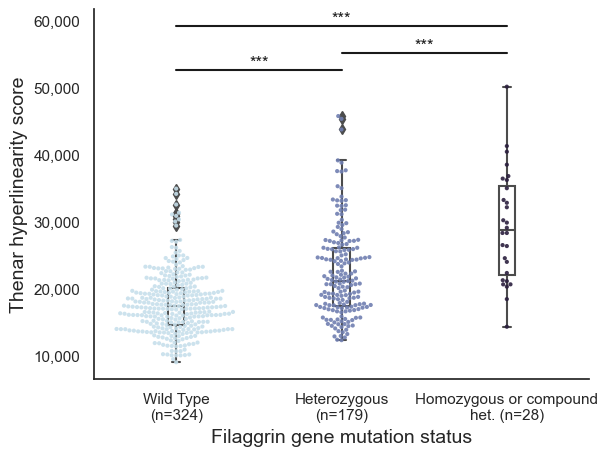

In [284]:
"""
Plot figure for thenar results 
(alternative colours)
"""

ya="Thenar scores"

###Load thenar results
a = pd.read_csv("thenarscoresalldf.csv")
ylab = 'Thenar hyperlinearity score'

###Add boxplot
plotbox7(a=a, xa="FLG status", ya=ya, ylabel=ylab, alpha=0.9, s=3, colours='alternative',
        altlabel=True )
ymax = a[ya].max()

###Add stats
## Note: values for statistical significant (result01, result12, result02) were 3 cells above, that is
   #result01_thenar  = "***"
   #result12_thenar  = "***"
   #result02_thenar  = "***"
addstats(result01_thenar , result12_thenar , result02_thenar , a, ya)

sns.despine()
plt.show()







# Extract palmar hyperlinearity scores

In [39]:
"""
P0.02 - score generation
"""
thres=0.02

palmwtscores= {} 
palmhetscores= {}
palmhomoscores= {}

extract_hyperlinearity(path_palm_wt, palmwtscores, thres)
extract_hyperlinearity(path_palm_het, palmhetscores, thres)
extract_hyperlinearity(path_palm_homo, palmhomoscores, thres)

print("done palm 0.02")

1 of 324
2 of 324
3 of 324
4 of 324
5 of 324
6 of 324
7 of 324
8 of 324
9 of 324
10 of 324
11 of 324
12 of 324
13 of 324
14 of 324
15 of 324
16 of 324
17 of 324
18 of 324
19 of 324
20 of 324
21 of 324
22 of 324
23 of 324
24 of 324
25 of 324
26 of 324
27 of 324
28 of 324
29 of 324
30 of 324
31 of 324
32 of 324
33 of 324
34 of 324
35 of 324
36 of 324
37 of 324
38 of 324
39 of 324
40 of 324
41 of 324
42 of 324
43 of 324
44 of 324
45 of 324
46 of 324
47 of 324
48 of 324
49 of 324
50 of 324
51 of 324
52 of 324
53 of 324
54 of 324
55 of 324
56 of 324
57 of 324
58 of 324
59 of 324
60 of 324
61 of 324
62 of 324
63 of 324
64 of 324
65 of 324
66 of 324
67 of 324
68 of 324
69 of 324
70 of 324
71 of 324
72 of 324
73 of 324
74 of 324
75 of 324
76 of 324
77 of 324
78 of 324
79 of 324
80 of 324
81 of 324
82 of 324
83 of 324
84 of 324
85 of 324
86 of 324
87 of 324
88 of 324
89 of 324
90 of 324
91 of 324
92 of 324
93 of 324
94 of 324
95 of 324
96 of 324
97 of 324
98 of 324
99 of 324
100 of 324
101 of 3

In [ ]:
"""
P0.02 - dataframe generation
"""
palmwtdf = pd.DataFrame.from_dict(palmwtscores, orient="index")
palmwtdf['ID'] = palmwtdf.index
palmwtdf = palmwtdf.assign(FLGstatus = 0)

palmhetdf = pd.DataFrame.from_dict(palmhetscores, orient="index")
palmhetdf['ID'] = palmhetdf.index
palmhetdf = palmhetdf.assign(FLGstatus = 1)

palmhomodf = pd.DataFrame.from_dict(palmhomoscores, orient="index")
palmhomodf['ID'] = palmhomodf.index
palmhomodf = palmhomodf.assign(FLGstatus = 2)




palmalldf = pd.concat([palmwtdf, palmhetdf, palmhomodf])
palmalldf.set_index(['ID'])

palmalldf.columns = ['Palmar scores', 'ID', 'FLG status']

palmalldf.to_csv("palmalldf.csv")
palmalldf.head()



In [121]:
"""
Statistics for palmar images
1. One-way ANOVA and Tukey
2. Standard deviation
"""

list_palmwtscores = list(palmwtscores.values())
list_palmhetscores = list(palmhetscores.values())
list_palmhomscores = list(palmhomoscores.values())
oneway_anova_and_tukey_pvalues(list_palmwtscores, list_palmhetscores, list_palmhomscores)


print(np.mean(list_palmwtscores))
st_dev = np.std(list_palmwtscores)
print("Standard deviation of the palm wt 0.02: " + str(round(st_dev,2)))
print(" ")

print(np.mean(list_palmhetscores))
st_dev = np.std(list_palmhetscores)
print("Standard deviation of the palm -/+ 0.02: " + str(round(st_dev,2)))
print(" ")

print(np.mean(list_palmhomscores))
st_dev = np.std(list_palmhomscores)
print("Standard deviation of the palm -/- 0.02: " + str(round(st_dev,2)))



Statistics=73.747, p=0.000
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2   meandiff  p-adj    lower      upper    reject
-------------------------------------------------------------
   Het    Hom   6087.6127   0.0      3631.9  8543.3255   True
   Het     WT  -4051.2413   0.0  -5176.5791 -2925.9036   True
   Hom     WT -10138.8541   0.0 -12519.0775 -7758.6306   True
-------------------------------------------------------------
21853.753086419754
Standard deviation of the palm wt 0.02: 4274.27
 
25904.99441340782
Standard deviation of the palm -/+ 0.02: 6122.59
 
31992.60714285714
Standard deviation of the palm -/- 0.02: 6884.14


In [122]:
""" 
Use results table above (P-VALUE COLUMN) to set number of stars for diagram
THIS NEEDS TO BE MODIFIED BASED ON RESULTS

*** signifies p-value ≤0.001
** signifies p-value ≤0.01
* signifies p-value ≤0.05
NS signifies p-value >0.05
"""
###01 = WT vs het (-/+)
result01_palmar = "***"
###12 = het (-/+) vs homo (-/-)
result12_palmar = "***"
###02 = WT vs homo (-/-)
result02_palmar = "***"



/var/folders/87/jz1lkxg141g8vvbsd1q4yh540000gn/T/ipykernel_8014/1362005422.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.swarmplot(x=xa, y=ya, data=a, palette=colours, alpha=alpha, s=s)


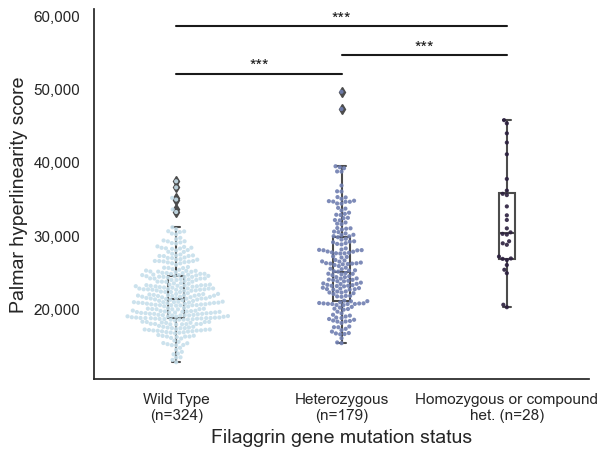

In [285]:
"""
Plot figure for palmar results 
(alternative colours)

"""

ya="Palmar scores"

###Load palmar results
a = pd.read_csv("palmalldf.csv")
ylab = 'Palmar hyperlinearity score'
plotbox7(a=a, xa="FLG status", ya=ya, ylabel=ylab, alpha=0.9, s=3,   colours="alternative",
        altlabel=True)
ymax = a[ya].max()

###Add stats
#Note: valeus for statistical significant (result01, result12, result02) were 3 cells above
#result01_palmar = "***"
#result12_palmar = "***"
#result02_palmar = "***"
addstats(result01_palmar, result12_palmar, result02_palmar, a, ya)


sns.despine()
plt.show()



# Plot external scores (Fig S5)

In [130]:
#os.chdir(###PATH HERE)

no = io.imread("no.png", as_gray=True) 
mild = io.imread("mild.png", as_gray=True) 
severe = io.imread("severe.png", as_gray=True) 

no1 = io.imread("no1.png", as_gray=True) 
suspected = io.imread("suspectede.png", as_gray=True) 
apparent = io.imread("apparent2.png", as_gray=True) 




In [131]:
external = [no, mild, severe, no1, suspected, apparent]    
names =  ['no t', 'mild t', 'severe t', 'no p', 'suspected p', 'apparent p']    

i = 0
threshold=0.02
for img in external:
        
       # input_path = os.path.join(path, image_path)
        img = resize(img, (512, 256))
        imagewt = sato(img, mode='constant')
        number = np.sum(imagewt>threshold)
        print(f"for {names[i]}: {number}")
        i = i+1
    
   


for no t: 17824
for mild t: 17381
for severe t: 26926
for no p: 23063
for suspected p: 23079
for apparent p: 38172


In [133]:
"""
Use scores above to set external image scores for later plot
"""
no_hyperlinearity_thenar_score= 17_824
mild_hyperlinearity_thenar_score= 17_381
severe_hyperlinearity_thenar_score= 26_926

no_hyperlinearity_palmar_score= 23_063
suspected_hyperlinearity_palmar_score= 23_079
apparent_hyperlinearity_palmar_score= 38_172

/var/folders/87/jz1lkxg141g8vvbsd1q4yh540000gn/T/ipykernel_8014/1362005422.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.swarmplot(x=xa, y=ya, data=a, palette=colours, alpha=alpha, s=s)


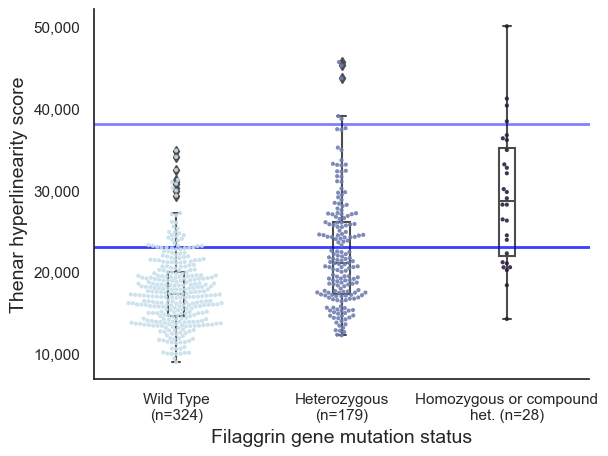

In [328]:
"""
Plot figure for THENAR results 
(alternative colours)
with external scores

"""

ya="Thenar scores"

###Load thenar results
a = pd.read_csv("thenarscoresalldf.csv")
ylab = 'Thenar hyperlinearity score'

plotbox7(a=a, xa="FLG status", ya=ya, ylabel=ylab, alpha=0.9, s=3,   colours="alternative",
        altlabel=True)
ymax = a[ya].max()

###Add stats
#Note: valeus for statistical significant (result01, result12, result02) were 3 cells above
#result01_palmar = "***"
#result12_palmar = "***"
#result02_palmar = "***"
#addstats(result01_palmar, result12_palmar, result02_palmar, a, ya)

##Add external scores (defined in part 1)
plt.axhline(y=no_hyperlinearity_palmar_score, alpha=0.5,
           linewidth=2, color='blue')
plt.axhline(y=suspected_hyperlinearity_palmar_score, alpha=0.5,
           linewidth=2, color='blue')
plt.axhline(y=apparent_hyperlinearity_palmar_score, alpha=0.5,
           linewidth=2, color='blue')

sns.despine()
plt.show()



/var/folders/87/jz1lkxg141g8vvbsd1q4yh540000gn/T/ipykernel_8014/1362005422.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.swarmplot(x=xa, y=ya, data=a, palette=colours, alpha=alpha, s=s)


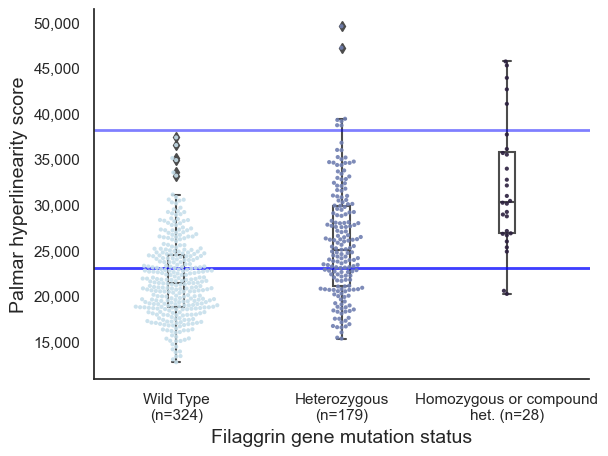

In [329]:
"""
Plot figure for palmar results 
(alternative colours)
with external scores

"""

ya="Palmar scores"

###Load palmar results
a = pd.read_csv("palmalldf.csv")
ylab = 'Palmar hyperlinearity score'
plotbox7(a=a, xa="FLG status", ya=ya, ylabel=ylab, alpha=0.9, s=3,   colours="alternative",
        altlabel=True)
ymax = a[ya].max()

###Add stats
#Note: valeus for statistical significant (result01, result12, result02) were 3 cells above
#result01_palmar = "***"
#result12_palmar = "***"
#result02_palmar = "***"
#addstats(result01_palmar, result12_palmar, result02_palmar, a, ya)

##Add external scores (defined in part 1)
plt.axhline(y=no_hyperlinearity_palmar_score, alpha=0.5,
           linewidth=2, color='blue')
plt.axhline(y=suspected_hyperlinearity_palmar_score, alpha=0.5,
           linewidth=2, color='blue')
plt.axhline(y=apparent_hyperlinearity_palmar_score, alpha=0.5,
           linewidth=2, color='blue')

sns.despine()
plt.show()

